# Dark Matter and Galaxy Formation 💫
Author: Charles Gannon 
email: cgannon@ucmerced.edu
## Introduction
In terms of mass, galaxies are dominated by dark matter. In fact, it is believed that almost 97% of the Milky Way's mass is in dark matter (Wilkison et al. 1999, Licquia et al 2015). Galaxies sit in the middle of dark matter structures called dark matter halos (as shown below)
<center>
<img src="images/galaxy-diagram.png" alt="Diagram of a galaxy in the middle of a dark matter halo"/>
</center>
Even though dark matter is invisible, the structure of galaxies cannot be understood without the gravitational effects of dark matter.

One way we try to understand how galaxies form is by running simulations of the universe and studying how galaxies form.
Because dark matter plays such a critical role in galaxy formation we often run simulations with *only* dark matter.
In this notebook we will put on "dark matter goggles" and see what our galaxy would look like if we could see dark matter.
We will analyze the output of *real* simulations of dark matter from the galacticus<sup>2, *</sup> (Benson 2012) galaxy formation model.
Using these simulations, we will explore a key prediction of dark matter: dark matter halos grow by merging with other dark matter halos.
We will explore the effects of dark matter mergers and look for the remnants of these mergers.
Finally, we will discuss how might we look for these effects in the universe.

<sup>2</sup> https://github.com/galacticusorg/galacticus

<sup>*</sup> Any similarity between the name "galacticus" and "Galactus" the fictional marvel charachter is purely coincedental, I asked myself. 

# Dependencies
Do not change

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from subscript.scripts.nodes import nodedata
from subscript.scripts.nfilters import nfilter_halos, nfilter_subhalos, nfand, nfilter_range, nfilter_all
from subscript.defaults import ParamKeys
from colossus.cosmology import cosmology
from colossus.halo import mass_so
from pyHalo.PresetModels.external import DMFromGalacticus
from pyHalo.Halos.HaloModels.TNFWFromParams import TNFWFromParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
from pyHalo.Halos.galacticus_util.galacticus_util import GalacticusUtil
from pyHalo.Halos.galacticus_util.galacticus_filter import *
from numpy import random
from scipy.optimize import minimize
from pyHalo.PresetModels.cdm import CDM
import lenstronomy
import matplotlib
from pyHalo.plotting_routines import plot_multiplane_convergence
from lenstronomy.LensModel.Profiles.tnfw import TNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [196]:
matplotlib.rc('font', size=22)

# Rendering / Plotting
Do not change

In [197]:
path_galacticus_small = "data/galacticus/dmo-small.hdf5"
path_galacticus_large = "data/galacticus/dmo-large.hdf5"
smallhalo = h5py.File(path_galacticus_small)
largehalo = h5py.File(path_galacticus_large)


def nfw(r, rs, rv, M):  
    """
    A NFW profile is a profile that is used to model the density profiles of dark matter halos
    Parameters
    -----------
    r : array_like
        Distance from center of the halo
    rs: float
        Scale radius of the halo
    rv: float
        Virial radius of the halo
    M: float
        Mass of the halo   
    
    Returns:
    -----------
    Returns:
    array_like
        NWF density profile evaluated at r
    """    

    p0 = M / 4 / np.pi / rs**3 / (np.log((rs + rv) / rs) - rv/(rs+rv))
    x = r / rs
    return p0 / x / (1 + x)**2

def render(halo, bins, include_substructure=False, mratio_min=1E-3): 
    """
    Returns the projected density of the halo (and optionally it's substructure)
    Parameters
    -----------
    halo: h5py.File
        Galacticus h5py output file, contains the data we will analyze
    bins: array_like
        Bins to use in both the x and y directions
    include_substructure: bool
        If true includes renders the density of subhalos
    mratio_min: float
        The minimum mass fraction of substructure to render

    Returns
    -----------
    Returns:
    array_like
        projected x coordinates
    array_like
        projected y coordinates       
    array_like
        Renders the projected Density of the halo and it's subhalos if requested
    """    
    rs, rv, rho0, m = nodedata(halo, [ParamKeys.scale_radius, ParamKeys.rvir, 'densityNormalizationTidalTruncationNFW', ParamKeys.mass_basic], nfilter=nfilter_halos)[0]
    meshgrid = np.asarray(np.asarray(np.meshgrid(bins,bins)))
    x,y = meshgrid[0].flatten(), meshgrid[1].flatten()
    host_rho = NFW().density_2d(x,y,rs,rho0,0,0)

    if not include_substructure:
        return x,y,host_rho
    
    rho_total = host_rho
    
    shkeys = [
                ParamKeys.scale_radius, 
                ParamKeys.rvir, 
                'radiusTidalTruncationNFW',
                'densityNormalizationTidalTruncationNFW',
                ParamKeys.x,
                ParamKeys.y
              ]
              
    
    _mmin = mratio_min * m
    _nfilter = nfand(
                     nfilter_subhalos(None),                  
                     nfilter_range(None, _mmin, np.inf, key=ParamKeys.mass_basic)
                    )
    shs = np.asarray(nodedata(halo, shkeys, nfilter=_nfilter)[0])

    for _rs, _rv, _rt, _rho0, _x, _y in shs.T:            
        select = np.sqrt((x - _x)**2 + (y - _y)**2) < 2 * _rt
        rho_total[select] += TNFW().density_2d(x[select],y[select],_rs,_rho0,_rt,_x, _y)

    return x,y, rho_total
    
def plothalo(ax, halo, bins, cmin, cmax, include_substructure=False, mration_min=1E-3, cbar=False):
    """
    Plots the 2d projected density of the halo as a heatmap
    Parameters
    -----------
    ax: 
        Pyplot axes to render on
    halo: h5py.File
        Galacticus h5py output file, contains the data we will analyze
    bins: array_like
        Bins to use in both the x and y directions
    include_substructure: bool
        If true includes renders the density of subhalos
    cmin: float
        Minimum projected density 
    cmin: float
        Maximum projected density
    cbar: bool
        Include a color bar
    """       
    rs, rv, m = nodedata(halo, [ParamKeys.scale_radius, ParamKeys.rvir, ParamKeys.mass], nfilter=nfilter_halos)[0]
    x,y,rho = render(halo, bins, include_substructure=include_substructure, mratio_min=mration_min)   
    rho[rho < 0] = cmin
    _cmin, _cmax = np.log10((cmin, cmax))
    *_, im = ax.hist2d(x,y, weights=np.log10(rho), bins=bins.shape[0], vmin=_cmin, vmax=_cmax)

    circle_rv = plt.Circle((0,0), rv, fill=False, edgecolor='red')
    circle_rs = plt.Circle((0,0), rs, fill=False, edgecolor='purple')

    ax.add_patch(circle_rs)


    if not cbar:
        return 
    
    cax = inset_axes(ax,
                        width="50%",       
                        height="4%",       
                        loc='upper center',
                        bbox_to_anchor=(0.1, -0.1, 1, 1),  
                        bbox_transform=ax.transAxes,
                        borderpad=0
                    )

    cbar = plt.colorbar(im, cax=cax, orientation="horizontal", pad=-0.3, extendfrac=0.2)
    cbar.set_label(r'$\log_{10} \left( \Sigma \right) ~$[$\mathrm{M}_\odot~\mathrm{Mpc}^{-2}$]', fontsize=10)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.xaxis.set_label_position('top')
    

def plothalo_1d(ax, halo, rbins, ylim, color='tab:blue', show_rs=False, scale_r=1, scale_d=1):
    """
    Plots the 1d radial density of the halo
    Parameters
    -----------
    ax: 
        Pyplot axes to render on
    halo: h5py.File
        Galacticus h5py output file, contains the data we will analyze
    rbins: array_like
        radial bins
    ylim: tuple[float, float]
        plott y limits
    color: str
        color of the plot
    show_rs: bool
        plot the scale radius
    scale_r: float
        rescale radii by this factor when plotting
    scale_d: float
        rescale density profile by this factor when plotting
    """       
    rs, rv, m = nodedata(halo, [ParamKeys.scale_radius, ParamKeys.rvir, ParamKeys.mass], nfilter=nfilter_halos)[0]


    ax.plot(rbins, nfw(rbins * scale_r,rs,rv,m) / scale_d,color=color)
    ax.plot(-rbins, nfw(rbins * scale_r,rs,rv,m) / scale_d,color=color)

    ax.set_ylim(ylim)
    ax.set_yscale("log")

    if not show_rs:
        return
    ax.vlines([-rs, rs], *ylim, color='tab:purple')

## Dark Matter Goggles 🥽
What would our Milky Way's dark matter halo look like if we could see dark matter? Here, we look at the density profile of a dark matter halo that is like the Milky Way (left) and that of a galaxy with a halo 10x the mass of the Milky Way.
This 10x more massive halo is called a *group mass* halo and has a mass of $M \sim 10^{13} M_\odot$.
Remember that density measures how much *mass* is in a given area. 

$$\mathrm{density} = \mathrm{mass} / \mathrm{volume}$$

This is shown in the bottom plots.

The top plots give the projected density of the of the halo. Projected basically means what we see if we were looking straight at the galaxy. Mathematically, projected density is similar to normal density, but instead of dividing by volume we divide by area

$$\text{projected density} = \mathrm{mass} / \mathrm{area}$$

The circle in purple shows the scale radius of the halo. The scale radius of the halo is where the density of the halo starts to fall off faster than in the inner part.

### Units
+ $M_\odot$ - A mass equivalent to the mass of the sun ($1.988 \cdot 10^{30} \mathrm{kg}$)
+ Mpc - (Mega parsec) A distance equal to 1,000,000 parsecs or ~ 3,261,598 light years.

Do you intuitively understand these measurements?


### Exercise
+ The distances on the x-axis of the lower plots and the x and y-axis of the upper plots are given in mega parsecs. Label this on the plot.
+ Fill in ```to_gpc3``` with the conversion factor to go from $M_\odot~\mathrm{Mpc}^{-3}$ to $\text{g cm}^{-3}$.
+ In the Milk Way plot projected density plot, add a dot the approximately where earth would be

### Discussion 
+ Quantitatively, how are the two different mass halos similar to each other? How are they different?
+ How does the dark matter density compare to the density of things you interact with in you daily life (most objects have a density of $\sim 1 \text{g cm}^{-3}$)

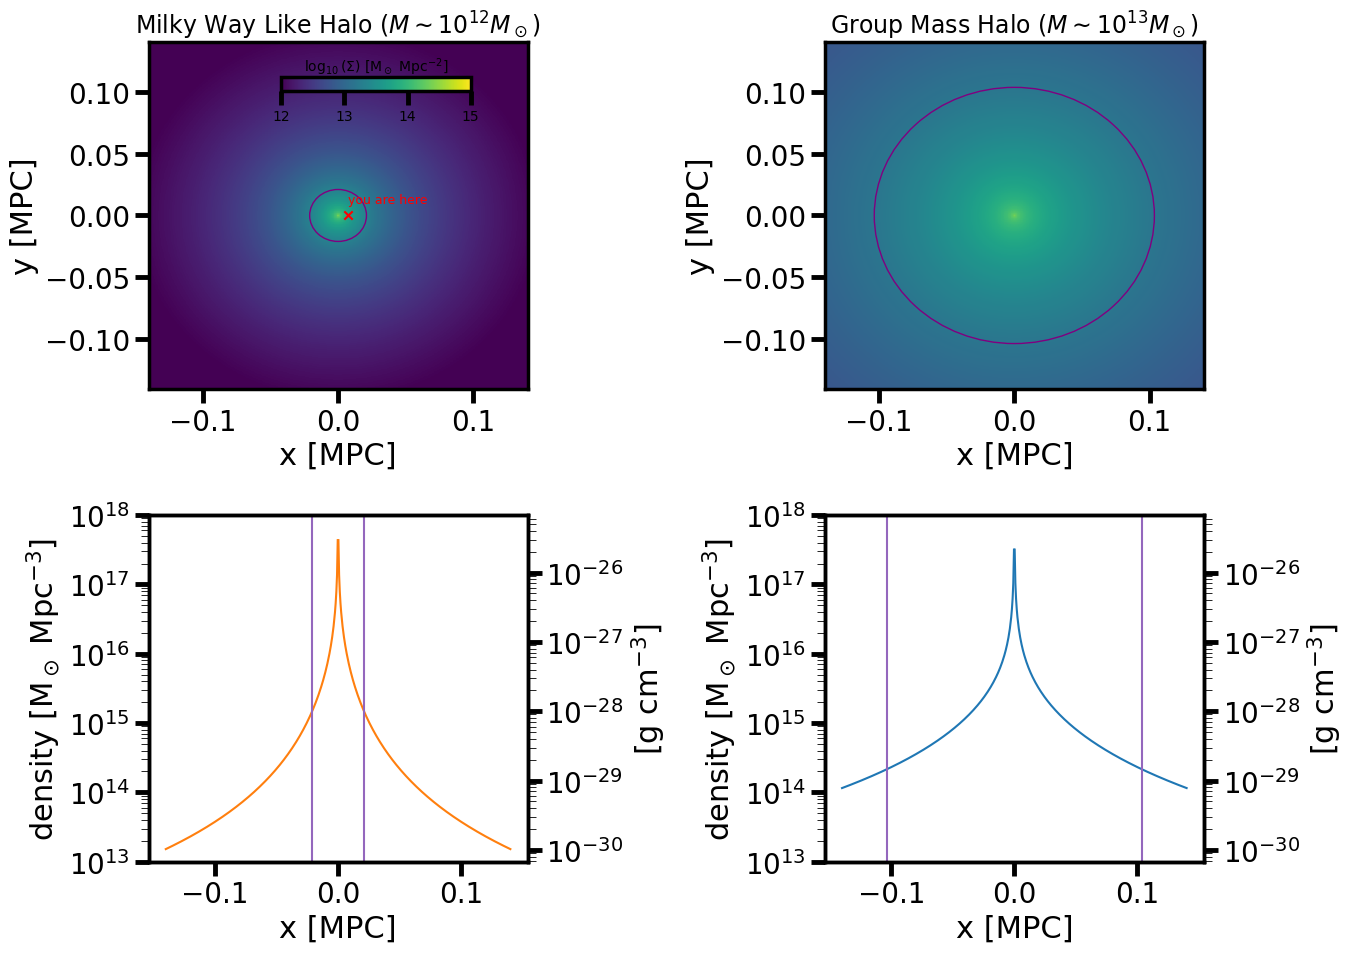

In [218]:
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(14,10))
bins = np.linspace(-0.14, 0.14, 500)
dlim = (1E12, 1E15)
bins1d = bins[bins > 0]
dlim1d =(1E13, 1E18)

# Fill out
to_gpcm3 = 6.77E-44

plothalo(axs[0][0], smallhalo, bins, dlim[0], dlim[1], include_substructure=False, cbar=True)
plothalo(axs[0][1], largehalo, bins, dlim[0], dlim[1], include_substructure=False)


plothalo_1d(axs[1][0], smallhalo, bins1d, ylim=dlim1d, show_rs=True, color='tab:orange');
plothalo_1d(axs[1][1], largehalo, bins1d, ylim=dlim1d, show_rs=True)


for ax in axs.flatten():
    ax.set_xlabel('x [MPC]')
    ax.set_ylabel('y [MPC]')

for ax in axs[1]:
    ax.set_ylabel('density [M$_\odot$ Mpc$^{-3}$]')
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    ax2.set_ylim(*(np.asarray(dlim1d) * to_gpcm3) )
    ax2.set_ylabel('[g cm$^{-3}$]')

axs[0][0].scatter((7.5E-3, ), (0,), color="red", marker="x")
axs[0][0].text(7.5E-3, 1E-2, "you are here", color="red", fontsize=9)

axs[0][0].set_title('Milky Way Like Halo ($M \sim 10^{12} M_\odot$)', fontsize=17)
axs[0][1].set_title('Group Mass Halo ($M \sim 10^{13} M_\odot$)', fontsize=17)
fig.tight_layout()

## Mergers 🛣  

Dark matter halos are thought to grow by merging with other dark matter halos in a process known as hierarchical structure formation.
The video below shows a galaxy forming in the TNG50 (Pillepich 2019) N-body cosmological simulation.
In an N-body simulation the gravitational interaction of many particles are simulated. 
Unlike our simulations, the TNG50 simulation includes both gas and dark matter. 
The dark matter is shown in the bottom left while the dark matter is shown in the main panel.
What do you notice?

<iframe width="560" height="315" src="https://www.youtube.com/embed/O674AZ_UKZk?si=4gATy0wuNSRxDg38" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

As dark matter halos merge and grow, some halos survive the merger process and begin to orbit the main halo. We call these subhalos (or substructure). To view the surviving subhalos in our simulation set.
```
 include_substructure = True
```

### Discussion 
+ Our galacticus are much faster and cheaper that the TNG50 simulations. However, they also make many more approximations (in fact we do not simulate). What are some differences you notice?
+ We mentioned that a galaxy can sit in the middle of the dark matter halo. Could a galaxy sit in the middle of the subhalos as well?

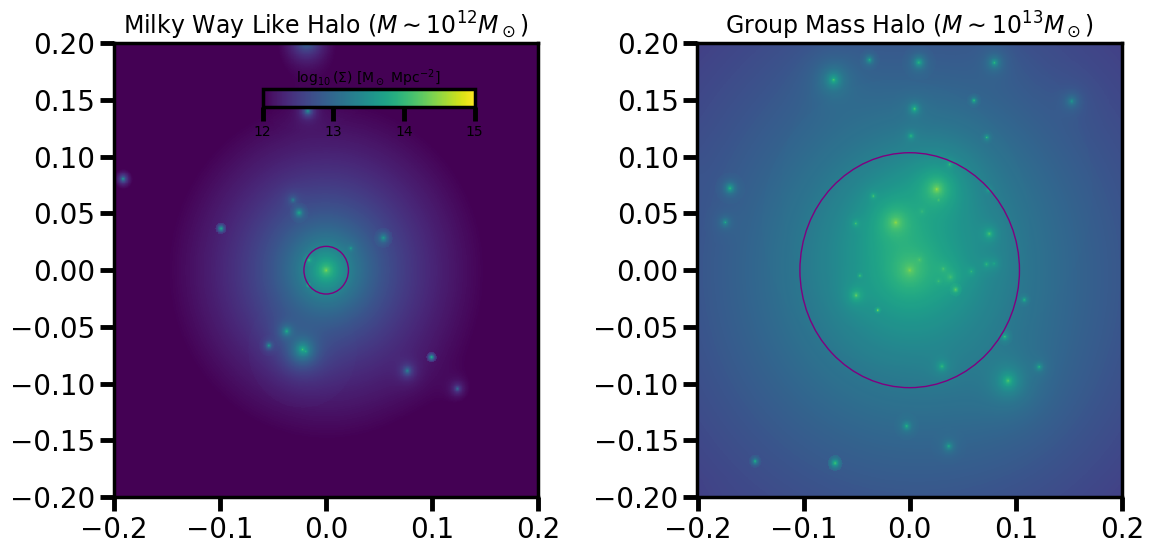

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
bins = np.linspace(-0.2, 0.2, 1000)
dlim = (1E12, 1E15)
# Set to true to turn substructure on 
include_substructure = True

plothalo(axs[0], smallhalo, bins, dlim[0], dlim[1], include_substructure=include_substructure, cbar=True)
plothalo(axs[1], largehalo, bins, dlim[0], dlim[1], include_substructure=include_substructure)

axs[0].set_title('Milky Way Like Halo ($M \sim 10^{12} M_\odot$)', fontsize=17)
axs[1].set_title('Group Mass Halo ($M \sim 10^{13} M_\odot$)', fontsize=17)

fig.tight_layout()

## Satellite Galaxies 🔭
So far we have only looked at dark matter.
However, we can't see dark matter.
What would we see if we actually looked through a telescope? Galaxies live in the center of dark matter halos, so we might be able to see a galaxy.
But which halos do they live in? Will the galaxies be bright enough for us to see? Thankfully, larger galaxies tend to live in larger dark matter halos.
That is given a dark matter halo M, there is a function that we can use to approximate the mass of its galaxy
$$ M_\star \approx f(M),$$
where $M_\star$ is the stellar mass of the galaxy and M is the mass of the dark matter halo.
Additionally larger galaxies live in larger dark matter halos. Mathematically we can say if $M_1 > M_2$, 
$$ M_{\star,1} = f(M_1) > f(M_2) = M_{\star,2}, $$ 
in otherwords, the stellar mass of a galaxy is a monotonically increasing function of halo mass. 
In addition, the brightness or luminosity of a galaxy is proportional to it's mass (more massive galaxies are brighter).
We will use this fact to determine which subhalos host visible satellite galaxies.

### Exercise
Here we will consider the case where we pretend we are looking at our dark matter halos through the JWST or hubble space telescope (which ever you prefer).

**key info:** In systems we are interested in, halos (and subhalos) with mass $m > 10^{12} M_\odot$ will host galaxies that may be visible to us. Place a star at the location of each subhalo in the image below that has mass $m > 10^{12} M_\odot$ on the **left** axis. 

#### Suggestions
+ You can use ```zip()``` to iterate over multiple arrays at once.
+ Changing ```nfilter=nfilter_halos``` to ```nfilter=nfilter_subhalos``` will select subhalos instead of the host halo

### Discussion
+ Sanity check: does everything seem right with our plots here?
+ How many galaxies would we expect to see based on our simulation? How does it compare to the total number of subhalos? For the rest of the workshop, we will discuss how we can observe the rest of the subhalos we can't see through a telescope because their galaxies are too dim (or they are so low mass they don't host a galaxy at all!).
+ When setting the size of the star, I use take the logarithm $\left(\log_{10} (m)\right)$ of the subhalo's mass. Why not just use mass directly?
+ A halo with mass $M = 10^{12} M_\odot$ will host a galaxy of mass $M_\star \sim 10^{10} M_\odot$. About how many stars are in this galaxy? Challenge: try to answer this without looking it up on google (or asking chatgpt) and without any math. Give a very approximate answer.

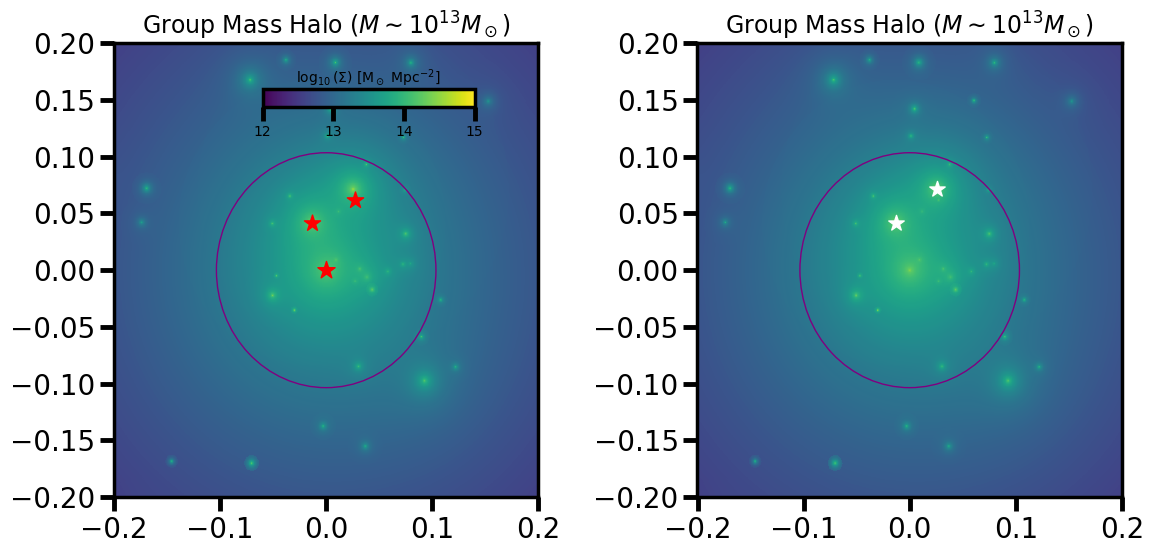

In [219]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
bins = np.linspace(-0.2, 0.2, 1000)
dlim = (1E12, 1E15)
include_substructure = True

plothalo(axs[0], largehalo, bins, dlim[0], dlim[1], include_substructure=include_substructure, cbar=True)
plothalo(axs[1], largehalo, bins, dlim[0], dlim[1], include_substructure=include_substructure)

# These are the parameters we want to get from our galacticus output
keys = [
        ParamKeys.mass_basic,
        ParamKeys.x,
        ParamKeys.y
       ]

# Get the mass, x, y position of the host halo
m, x, y = nodedata(largehalo, keys, nfilter=nfilter_halos)[0]

# places a star logo at the center of the central galaxy
# Make the size of the star increase with the mass of the halo accorind to the formula
# area ~ log10(m)**2
axs[0].scatter(x,y, color="red", s=np.log10(m)**2, marker='*')

for ax in axs:
    ax.set_title('Group Mass Halo ($M \sim 10^{13} M_\odot$)', fontsize=17)

# Fill out here

# Part 1
sh_m, sh_x, sh_y = nodedata(largehalo, keys, nfilter=nfilter_subhalos)[0]

for _m, _x, _y in zip(sh_m, sh_x, sh_y):    
    if _m < 1E12:
        continue
    axs[0].scatter(_x,_y, color="red", s=np.log10(_m)**2, marker='*') 


#Part 2
keys2 = [
            ParamKeys.mass_bound,
        ]
sh_mb = np.asarray(nodedata(largehalo, ParamKeys.mass_bound, nfilter=nfilter_subhalos)[0])
mb_sorti = np.argsort(-sh_mb)

for n in range(2): 
    i = mb_sorti[n] 
    axs[1].scatter(sh_x[i],sh_y[i], color="white", s=np.log10(sh_mb[i])**2, marker='*')  

fig.tight_layout()

## Tidal Forces 🏖 

Tidal forces happen when there is a difference in the gravitational force experienced at one point vs another.
Tides are responsible for a wide range of phenomena, from the rings of Saturn to the tides at a beach.
Subhalos also experience tidal due to the gravitational force of the host halo, and will lose large amounts of mass (On average, galacticus predicts a subhalo will lose around $97\%$) of it's mass (Gannon et al. 2025). Below is a video of tidal stripping in action.

<iframe width="560" height="315" src="https://www.youtube.com/embed/M7byDz1ehlg?si=_5Tu1dY81M3c5WuB" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

The masses we were using to determine the brightnesses of galaxies are the mass of the subhalo *before* it is tidally stripped. This is correct because the galaxy will form before the subhalo merges with its host. 
However, the dark matter surrounding the galaxy may be stripped away during the merging process.
This is why one of the dark matter halos we placed a star on was not very dense in our image.
It was very massive when it merged, but has since lost its mass to tidal stripping.

### Challenge
Place a star on the 2 subhalos with the most mass remaining after tidal stripping.
+ *Hint* the key for the subhalo's mass after tidal stripping is ```ParamKeys.mass_bound```
+ *Hint* you will need to sort the mass array and you will need to keep track of which coordinate goes with each mass after sorting

#### Sorting
Arrays can be sorted by using ```np.sort``` or using ```np.argsort```
+ Using ```np.sort``` on an array ```[3,2,5]``` will return the sorted array ```[2,3,5]```.
+ Using ```np.argsort``` on an array ```[3,2,5]``` will return the sorted indexes ```[1,0,2]```.


## Citations

Benson, A. J. (2012). Galacticus: A semi-analytic model of galaxy formation. New Astronomy, 17(2), 175-197.

Gannon, Charles, et al. "Dark Matter Substructure: A Lensing Perspective." arXiv preprint arXiv:2501.17362 (2025).

Licquia, T. C., & Newman, J. A. (2015). Improved estimates of the Milky Way’s stellar mass and star formation rate from hierarchical Bayesian meta-analysis. The Astrophysical Journal, 806(1), 96.

Pillepich, A., Nelson, D., Springel, V., Pakmor, R., Torrey, P., Weinberger, R., ... & Hernquist, L. (2019). First results from the TNG50 simulation: the evolution of stellar and gaseous discs across cosmic time. Monthly Notices of the Royal Astronomical Society, 490(3), 3196-3233. 

Wilkinson, M. I., & Evans, N. W. (1999). The present and future mass of the Milky Way halo. Monthly Notices of the Royal Astronomical Society, 310(3), 645-662. 





